**cnn**

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [ ]:
import os
import pandas as pd

healthy_dirs = [
    r'/content/drive/MyDrive/Osteoporosis Knee X-ray/normal',
    r'/content/drive/MyDrive/normal/normal',
    r'/content/drive/MyDrive/Osteoporosis Knee Dataset/Normal',
    r'/content/drive/MyDrive/osteoporosis/normal'
]

osteoporosis_dirs = [
    r'/content/drive/MyDrive/Osteoporosis Knee X-ray/osteoporosis',
    r'/content/drive/MyDrive/osteoporosis/osteoporosis',
    r'/content/drive/MyDrive/Osteoporosis Knee Dataset/Osteoporosis',
    r'/content/drive/MyDrive/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
1  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
2  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
3  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
4  /content/drive/MyDrive/Osteoporosis Knee X-ray...  Healthy
labels
Osteoporosis    979
Healthy         780
Name: count, dtype: int64


In [ ]:
knee_osteoporosis_df.shape

(1759, 2)

In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1407, 2)
(528, 2)
(352, 2)
(1231, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 352 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

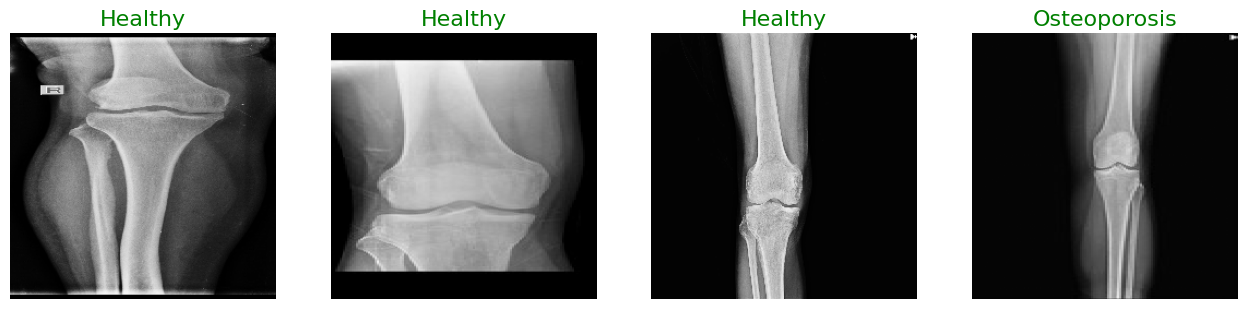

In [ ]:
show_knee_images(train)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 128)         │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 73, 73, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 256)         │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,0

 Total params: 15,609,474 (59.55 MB)

 Trainable params: 15,603,074 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
130/352 ━━━━━━━━━━━━━━━━━━━━ 5:17 1s/step - accuracy: 0.5242 - loss: 1.7038

In [ ]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 31s 89ms/step - loss: 0.1074 - accuracy: 0.9630 - val_loss: 0.1957 - val_accuracy: 0.9176


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 9s 66ms/step - loss: 0.1625 - accuracy: 0.9337


[0.1625158041715622, 0.9337121248245239]

In [ ]:
history2 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 32s 92ms/step - loss: 0.1114 - accuracy: 0.9623 - val_loss: 0.1618 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 9s 65ms/step - loss: 0.1304 - accuracy: 0.9318


[0.1304173618555069, 0.9318181872367859]

In [ ]:
model.save("Osteoporosis_Model_binary.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

132/132 [==============================] - 8s 57ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.94      0.91      0.92       233
Osteoporosis       0.93      0.95      0.94       295

    accuracy                           0.93       528
   macro avg       0.93      0.93      0.93       528
weighted avg       0.93      0.93      0.93       528

Accuracy of the Model: 93.2%


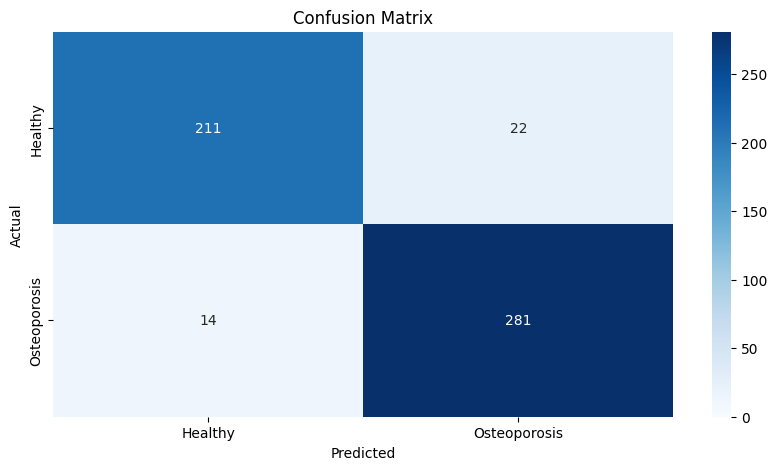

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

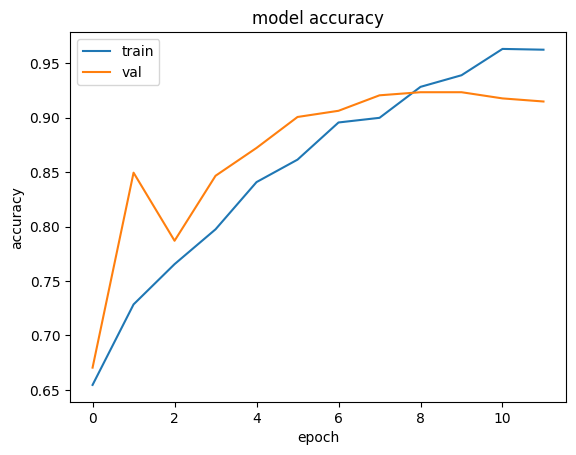

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] )
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

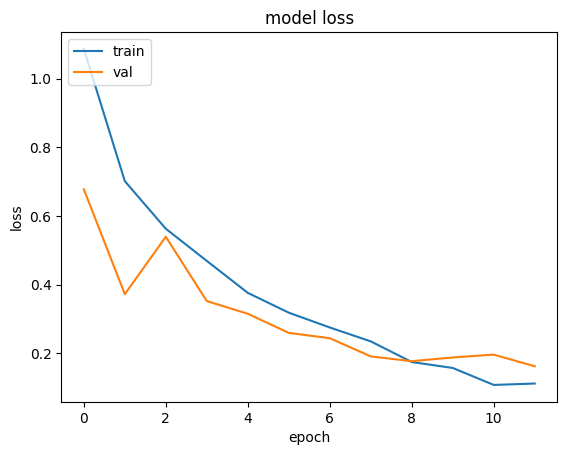

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**VGG16**

In [ ]:
train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1407, 2)
(176, 2)
(176, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))

    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)

        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

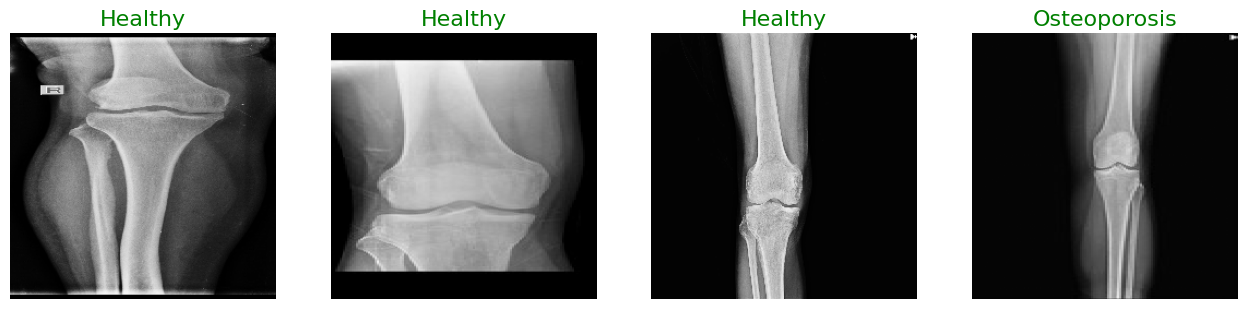

In [ ]:
show_knee_images(train)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.applications import VGG16
import tensorflow as tf

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg16_model.output

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.7)(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

model = Model(inputs=vgg16_model.input, outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 [==============================] - 864s 2s/step - loss: 0.6918 - accuracy: 0.5551 - val_loss: 0.6906 - val_accuracy: 0.5455
Epoch 2/5
352/352 [==============================] - 44s 124ms/step - loss: 0.6829 - accuracy: 0.5622 - val_loss: 0.7960 - val_accuracy: 0.5455
Epoch 3/5
352/352 [==============================] - 47s 132ms/step - loss: 0.6343 - accuracy: 0.6055 - val_loss: 0.6347 - val_accuracy: 0.7557
Epoch 4/5
352/352 [==============================] - 45s 127ms/step - loss: 0.5498 - accuracy: 0.7704 - val_loss: 0.5365 - val_accuracy: 0.7784
Epoch 5/5
352/352 [==============================] - 45s 129ms/step - loss: 0.4870 - accuracy: 0.7910 - val_loss: 0.4867 - val_accuracy: 0.7898


In [ ]:
history1 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
352/352 [==============================] - 53s 149ms/step - loss: 0.4522 - accuracy: 0.8117 - val_loss: 0.4001 - val_accuracy: 0.8466
Epoch 2/5
352/352 [==============================] - 45s 126ms/step - loss: 0.4288 - accuracy: 0.8252 - val_loss: 0.4060 - val_accuracy: 0.8182
Epoch 3/5
352/352 [==============================] - 45s 129ms/step - loss: 0.3729 - accuracy: 0.8571 - val_loss: 0.4074 - val_accuracy: 0.8295
Epoch 4/5
352/352 [==============================] - 44s 125ms/step - loss: 0.3317 - accuracy: 0.8749 - val_loss: 0.3250 - val_accuracy: 0.8750
Epoch 5/5
352/352 [==============================] - 48s 136ms/step - loss: 0.2877 - accuracy: 0.8884 - val_loss: 0.3847 - val_accuracy: 0.8466


In [ ]:
model.evaluate(test, verbose=1)

132/132 [==============================] - 10s 77ms/step - loss: 0.1360 - accuracy: 0.9432


[0.1360384225845337, 0.9431818127632141]

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 73s 2s/step - loss: 0.3861 - accuracy: 0.8523


[0.38606855273246765, 0.8522727489471436]

In [ ]:
history3 = model.fit(train, epochs=2, validation_data=val, verbose=1)

Epoch 1/2
352/352 [==============================] - 48s 137ms/step - loss: 0.2397 - accuracy: 0.9147 - val_loss: 0.2731 - val_accuracy: 0.8977
Epoch 2/2
352/352 [==============================] - 44s 125ms/step - loss: 0.2014 - accuracy: 0.9289 - val_loss: 0.2956 - val_accuracy: 0.8750


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 90ms/step - loss: 0.2617 - accuracy: 0.8920


[0.26167652010917664, 0.8920454382896423]

In [ ]:
history4 = model.fit(train,epochs=4,validation_data=val,verbose=1)

Epoch 1/4
352/352 [==============================] - 46s 130ms/step - loss: 0.1852 - accuracy: 0.9303 - val_loss: 0.3253 - val_accuracy: 0.8636
Epoch 2/4
352/352 [==============================] - 46s 130ms/step - loss: 0.1638 - accuracy: 0.9417 - val_loss: 0.2827 - val_accuracy: 0.8920
Epoch 3/4
352/352 [==============================] - 44s 125ms/step - loss: 0.1467 - accuracy: 0.9410 - val_loss: 0.2414 - val_accuracy: 0.9148
Epoch 4/4
352/352 [==============================] - 44s 126ms/step - loss: 0.1388 - accuracy: 0.9481 - val_loss: 0.1647 - val_accuracy: 0.9205


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 85ms/step - loss: 0.1496 - accuracy: 0.9375


[0.14959166944026947, 0.9375]

In [ ]:
history5 = model.fit(train,epochs=2,validation_data=val,verbose=1)

Epoch 1/2
352/352 [==============================] - 46s 131ms/step - loss: 0.1139 - accuracy: 0.9552 - val_loss: 0.2307 - val_accuracy: 0.9034
Epoch 2/2
352/352 [==============================] - 44s 126ms/step - loss: 0.1199 - accuracy: 0.9545 - val_loss: 0.2154 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 93ms/step - loss: 0.1402 - accuracy: 0.9205


[0.14018993079662323, 0.9204545617103577]

In [ ]:
history6 = model.fit(train,epochs=1,validation_data=val,verbose=1)

352/352 [==============================] - 46s 130ms/step - loss: 0.0901 - accuracy: 0.9630 - val_loss: 0.1635 - val_accuracy: 0.9261


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 4s 90ms/step - loss: 0.1339 - accuracy: 0.9489


[0.1339380294084549, 0.9488636255264282]

In [ ]:
history7 = model.fit(train,epochs=1,validation_data=val,verbose=1)

352/352 [==============================] - 49s 139ms/step - loss: 0.0889 - accuracy: 0.9623 - val_loss: 0.1576 - val_accuracy: 0.9148


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 3s 62ms/step - loss: 0.1372 - accuracy: 0.9432


[0.1372024118900299, 0.9431818127632141]

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 4s 73ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.91111   0.97619   0.94253        84
Osteoporosis    0.97674   0.91304   0.94382        92

    accuracy                        0.94318       176
   macro avg    0.94393   0.94462   0.94317       176
weighted avg    0.94542   0.94318   0.94320       176

Accuracy of the Model: 0.94318
Precision of the Model: 0.94542
Recall Score of the Model: 0.94318
f1 Score of the Model: 0.94320


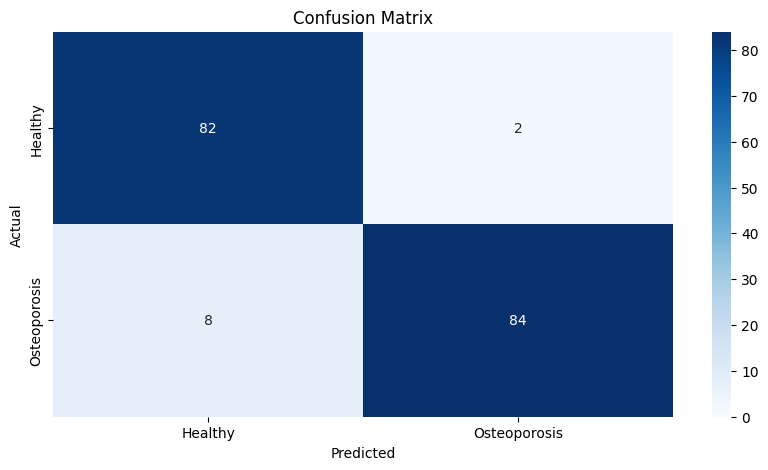

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

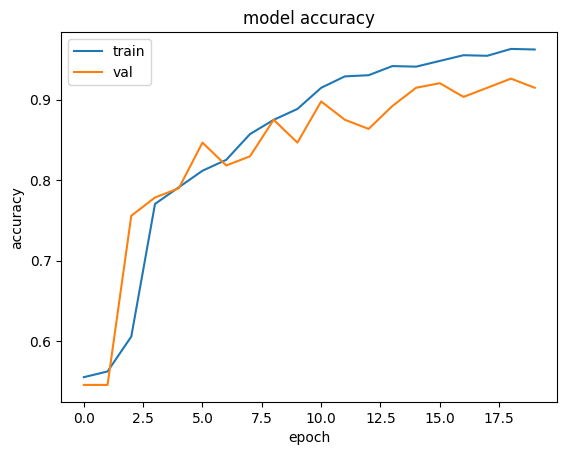

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history3.history['accuracy']+ history4.history['accuracy']+ history5.history['accuracy']+ history6.history['accuracy']+ history7.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy']+ history5.history['val_accuracy']+ history6.history['val_accuracy']+ history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

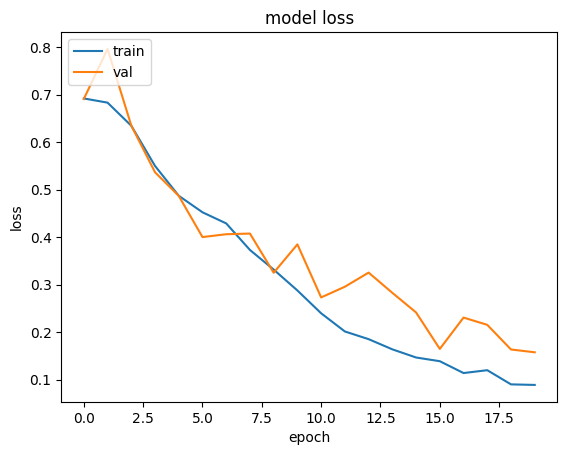

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history3.history['loss']+ history4.history['loss']+ history5.history['loss']+ history6.history['loss']+ history7.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss']+ history5.history['val_loss']+ history6.history['val_loss']+ history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**ResNet**

In [ ]:
train_data, remaining_data = train_test_split(knee_osteoporosis_data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(1407, 2)
(176, 2)
(176, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_data,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_data,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_data,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1407 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.
Found 176 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [ ]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))

    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)

        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

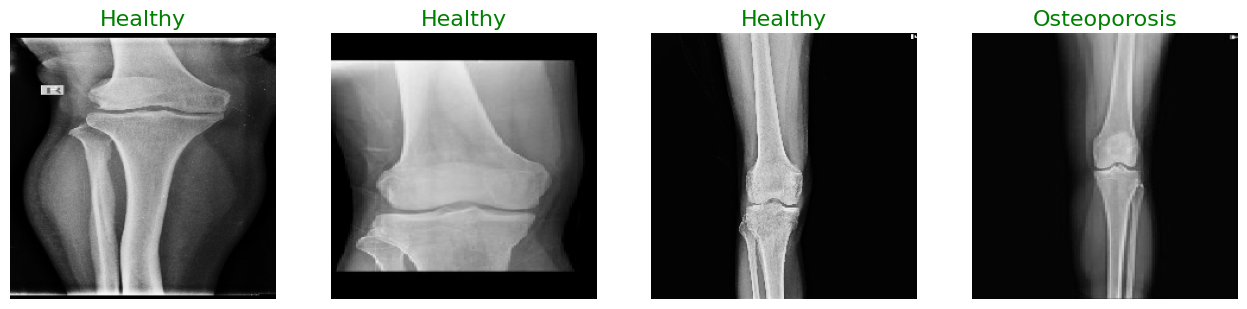

In [ ]:
show_knee_images(train)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet50_model.output

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

model = Model(inputs=resnet50_model.input, outputs=output)

optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 75,152,386 (286.68 MB)

 Trainable params: 75,099,266 (286.48 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
147/352 ━━━━━━━━━━━━━━━━━━━━ 5:58 2s/step - accuracy: 0.5335 - loss: 0.6931

KeyboardInterrupt: 

In [ ]:
history1 = model.fit(train, epochs=15, validation_data=val, verbose=1)

Epoch 1/15
352/352 [==============================] - 45s 129ms/step - loss: 6.5718e-05 - accuracy: 1.0000 - val_loss: 0.8740 - val_accuracy: 0.8977
Epoch 2/15
352/352 [==============================] - 46s 131ms/step - loss: 3.8096e-05 - accuracy: 1.0000 - val_loss: 0.9335 - val_accuracy: 0.8920
Epoch 3/15
352/352 [==============================] - 44s 126ms/step - loss: 2.4600e-05 - accuracy: 1.0000 - val_loss: 0.9713 - val_accuracy: 0.8807
Epoch 4/15
352/352 [==============================] - 44s 125ms/step - loss: 1.4340e-05 - accuracy: 1.0000 - val_loss: 1.0307 - val_accuracy: 0.8807
Epoch 5/15
352/352 [==============================] - 44s 125ms/step - loss: 1.0647e-05 - accuracy: 1.0000 - val_loss: 1.0921 - val_accuracy: 0.9034
Epoch 6/15
352/352 [==============================] - 45s 126ms/step - loss: 6.1139e-06 - accuracy: 1.0000 - val_loss: 1.1215 - val_accuracy: 0.8920
Epoch 7/15
352/352 [==============================] - 44s 124ms/step - loss: 5.5313e-06 - accuracy: 1.0000

In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 61s 1s/step - loss: 0.7624 - accuracy: 0.9489


[0.7624315619468689, 0.9488636255264282]

In [ ]:
history2 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 48s 136ms/step - loss: 5.7864e-07 - accuracy: 1.0000 - val_loss: 1.5383 - val_accuracy: 0.8864


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 5s 117ms/step - loss: 0.7726 - accuracy: 0.9489


[0.7726213932037354, 0.9488636255264282]

In [ ]:
history3 = model.fit(train, epochs=1, validation_data=val, verbose=1)

352/352 [==============================] - 48s 136ms/step - loss: 3.4102e-07 - accuracy: 1.0000 - val_loss: 1.6311 - val_accuracy: 0.8920


In [ ]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 5s 114ms/step - loss: 0.8291 - accuracy: 0.9489


[0.8290848135948181, 0.9488636255264282]

In [ ]:
model.save("Osteoporosis_Model_binary.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

44/44 [==============================] - 5s 74ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

y_test = test_data.labels
print(classification_report(y_test, pred2, digits=5))
print("Accuracy of the Model: {:.5f}".format(accuracy_score(y_test, pred2)))
precision = precision_score(y_test, pred2, average='weighted')
print("Precision of the Model: {:.5f}".format(precision))
recall = recall_score(y_test, pred2, average='weighted')
print("Recall Score of the Model: {:.5f}".format(recall))
f1 = f1_score(y_test, pred2, average='weighted')
print("f1 Score of the Model: {:.5f}".format(f1))

              precision    recall  f1-score   support

     Healthy    0.93103   0.96429   0.94737        84
Osteoporosis    0.96629   0.93478   0.95028        92

    accuracy                        0.94886       176
   macro avg    0.94866   0.94953   0.94882       176
weighted avg    0.94946   0.94886   0.94889       176

Accuracy of the Model: 0.94886
Precision of the Model: 0.94946
Recall Score of the Model: 0.94886
f1 Score of the Model: 0.94889


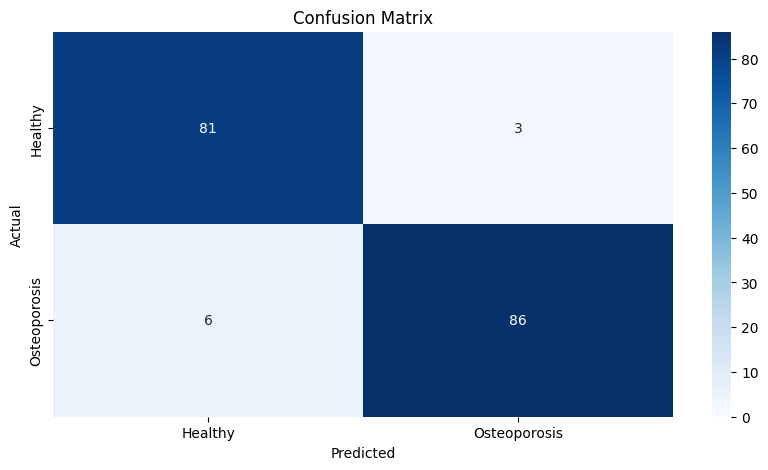

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

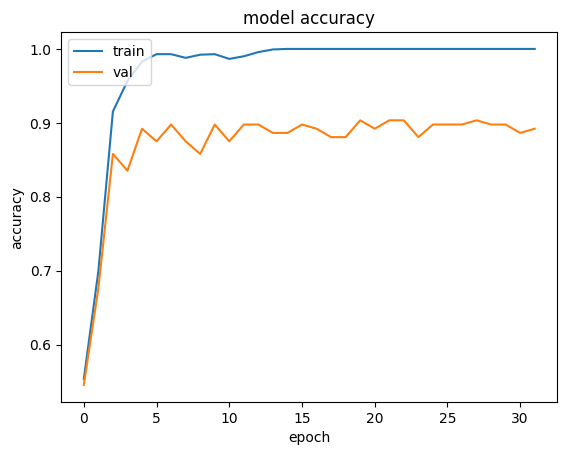

In [ ]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

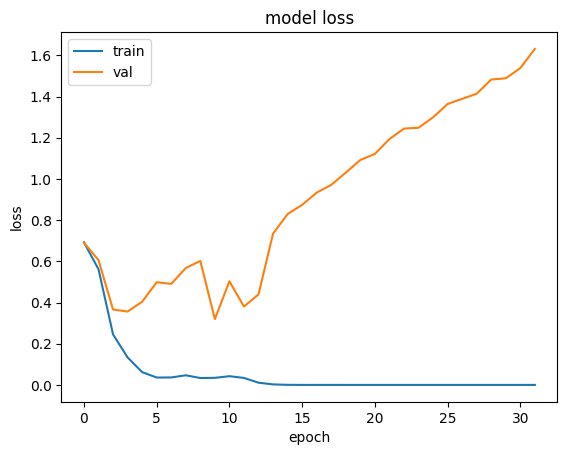

In [ ]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()